In [51]:
!pip install prophet
!pip install statsmodels
!pip install tensorflow

# Importing Libraries

In [52]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.vector_ar.var_model import VAR
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Attention, RepeatVector, TimeDistributed
from statsmodels.tsa.ar_model import AutoReg

# Importing Data

In [53]:
data = pd.read_csv(r'Sales.csv')

# Getting some info about the data

In [54]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


# Statistical measures about the data

In [55]:
data.describe()

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


# First 5 rows in the dataset

In [56]:
data.head()

,date,store,item,sales
0,1/1/2013,1,1,13
1,1/2/2013,1,1,11
2,1/3/2013,1,1,14
3,1/4/2013,1,1,13
4,1/5/2013,1,1,10


# Last 5 rows in the dataset

In [57]:
data.tail()

,date,store,item,sales
912995,12/27/2017,10,50,63
912996,12/28/2017,10,50,59
912997,12/29/2017,10,50,74
912998,12/30/2017,10,50,62
912999,12/31/2017,10,50,82


# Getting types for each feature

In [58]:
data.dtypes

date     object
store     int64
item      int64
sales     int64
dtype: object

# Number of rows and columns in the dataset

In [59]:
data.shape

(913000, 4)

# Checking for missing values

In [60]:
data.isnull().sum()

date     0
store    0
item     0
sales    0
dtype: int64

# Number of duplicated rows

In [61]:
data.duplicated().sum()

0

# Convert data from object datatype to dateTime dataType

In [62]:
data['date'] = pd.to_datetime(data['date'])

In [63]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   store   913000 non-null  int64         
 2   item    913000 non-null  int64         
 3   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 27.9 MB


# Grouping data by store and item

In [64]:
store_item_groups = data.groupby(['store', 'item']).sum().reset_index()

C:\Users\Anas\AppData\Local\Temp\ipykernel_3752\3234189821.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  store_item_groups = data.groupby(['store', 'item']).sum().reset_index()


In [65]:
store_item_groups.head()

,store,item,sales
0,1,1,36468
1,1,2,97050
2,1,3,60638
3,1,4,36440
4,1,5,30335


# Preparing time series data 

In [66]:
def prepare_timeseries_data(df, item, store):
    item_store_data = df[(df['item'] == item) & (df['store'] == store)]
    item_store_data = item_store_data[['date', 'sales']].set_index('date').resample('D').sum().reset_index()
    item_store_data.rename(columns={'sales': 'y', 'date': 'ds'}, inplace=True)  
    return item_store_data

# Preparing data for item 1 in store 1

In [67]:
item = 1
store = 1
ts_data = prepare_timeseries_data(data, item, store)
ts_data.head()

,ds,y
0,2013-01-01,13
1,2013-01-02,11
2,2013-01-03,14
3,2013-01-04,13
4,2013-01-05,10


# Splitting the data into training and testing sets

In [68]:
train_data = ts_data[:-30]  # Assigns all data except the last 30 days to the training dataset
test_data = ts_data[-30:]   # Assigns the last 30 days of data to the testing dataset

## Creating and training a Prophet model 

In [69]:
model = Prophet()
model.fit(train_data)

17:40:22 - cmdstanpy - INFO - Chain [1] start processing
17:40:22 - cmdstanpy - INFO - Chain [1] done processing


## Making predictions

In [70]:
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

## Displaying the results 

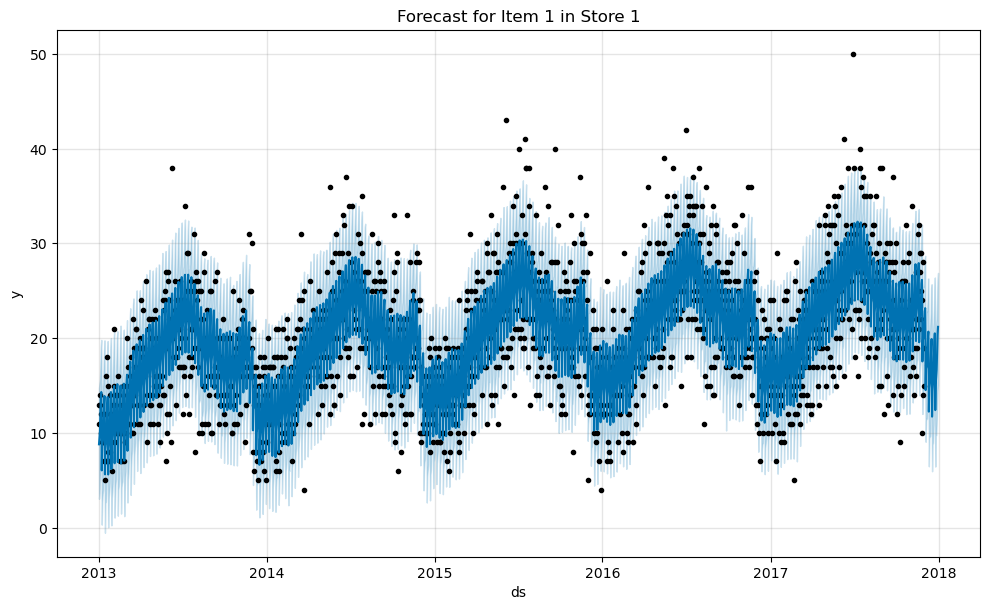

In [71]:
fig = model.plot(forecast)
plt.title(f'Forecast for Item {item} in Store {store}')
plt.show()

## Calculating errors

In [72]:
predicted_sales = forecast.tail(30)['yhat'].values
actual_sales = test_data['y'].values

mse = mean_squared_error(actual_sales, predicted_sales)
mae = mean_absolute_error(actual_sales, predicted_sales)
r2 = r2_score(actual_sales, predicted_sales)

print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'R2: {r2}')


MSE: 21.66879125528913
MAE: 3.5802035029972186
R2: 0.2820677319334334


In [73]:
predicted_sales = forecast.tail(30)['yhat'].values
actual_sales = test_data['y'].values

# Calculate the differences
differences = actual_sales - predicted_sales

# Create a DataFrame to display the results
results_df = pd.DataFrame({
    'Date': test_data['ds'].values,
    'Actual Sales': actual_sales,
    'Predicted Sales': predicted_sales,
    'Difference': differences
})

# Display the DataFrame
print(results_df)

# Optionally, you can save the results to a CSV file
results_df.to_csv('sales_comparison.csv', index=False)


         Date  Actual Sales  Predicted Sales  Difference
0  2017-12-02            16        22.824390   -6.824390
1  2017-12-03            31        23.174154    7.825846
2  2017-12-04             7        14.527692   -7.527692
3  2017-12-05            20        16.785603    3.214397
4  2017-12-06            17        16.995746    0.004254
5  2017-12-07            18        17.302292    0.697708
6  2017-12-08            17        18.588506   -1.588506
7  2017-12-09            27        20.172134    6.827866
8  2017-12-10            20        20.696576   -0.696576
9  2017-12-11            20        12.251112    7.748888
10 2017-12-12            13        14.732085   -1.732085
11 2017-12-13            17        15.182693    1.817307
12 2017-12-14            14        15.742161   -1.742161
13 2017-12-15            16        17.288639   -1.288639
14 2017-12-16            15        19.134705   -4.134705
15 2017-12-17            22        19.918663    2.081337
16 2017-12-18            19    

## Plot actual sales vs predicted sales

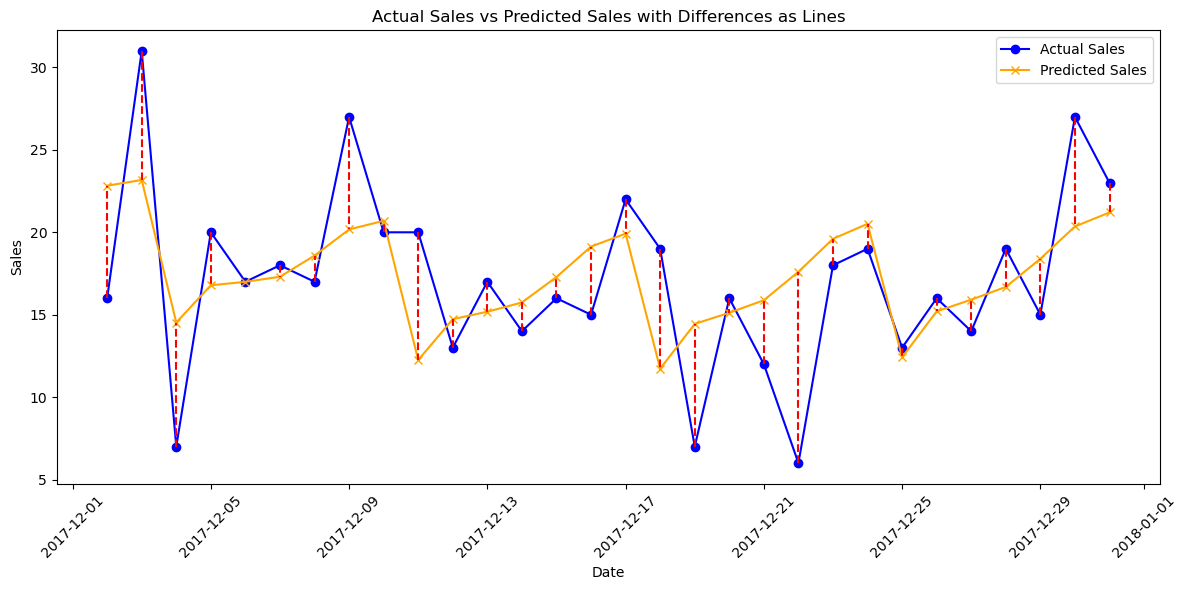

In [74]:
plt.figure(figsize=(12, 6))

# Plot actual sales
plt.plot(results_df['Date'], results_df['Actual Sales'], label='Actual Sales', color='blue', marker='o')

# Plot predicted sales
plt.plot(results_df['Date'], results_df['Predicted Sales'], label='Predicted Sales', color='orange', marker='x')

# Plot the difference as lines connecting actual and predicted points
for i in range(len(results_df)):
    plt.plot([results_df['Date'][i], results_df['Date'][i]], 
             [results_df['Actual Sales'][i], results_df['Predicted Sales'][i]], 
             color='red', linestyle='--')

# Adding titles and labels
plt.title('Actual Sales vs Predicted Sales with Differences as Lines')
plt.xlabel('Date')
plt.ylabel('Sales')

# Rotating date labels for better readability
plt.xticks(rotation=45)

# Adding a legend
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()


# Preparing the data for Linear Regression

In [75]:
ts_data = prepare_timeseries_data(data, item, store)
X = np.arange(len(ts_data)).reshape(-1, 1)  # Time indices
y = ts_data['y'].values  # Sales data

## Splitting the data

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

## Creating and training the model

In [77]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

## Making predictions

In [78]:
y_pred = model.predict(X_test)

## Evaluating the model

In [79]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'R2: {r2}')

MSE: 46.688792939539184
MAE: 5.534368246151014
R2: -0.0383038401149014


# ARIMA (AutoRegressive Integrated Moving Average)

## Preparing the data for ARIMA

In [80]:
ts_data = prepare_timeseries_data(data, item, store)
y = ts_data['y'].values

## Splitting the data


In [81]:
train_data, test_data = y[:-30], y[-30:]

## Fitting the ARIMA model

In [82]:
model = ARIMA(train_data, order=(5, 1, 0))
model_fit = model.fit()

## Making predictions

In [83]:
predictions = model_fit.forecast(steps=30)

## Evaluating the model

In [84]:
mse = mean_squared_error(test_data, predictions)
mae = mean_absolute_error(test_data, predictions)
r2 = r2_score(test_data, predictions)

print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'R2: {r2}')

MSE: 33.00528175214184
MAE: 4.21658076821216
R2: -0.09353385278043191


# Exponential Smoothing (ETS)

## Fitting the ETS model

In [85]:
model = ExponentialSmoothing(train_data, seasonal='add', trend='add', seasonal_periods=12)
model_fit = model.fit()

## Making predictions

In [86]:
predictions = model_fit.forecast(steps=30)

## Evaluating the model

In [87]:
mse = mean_squared_error(test_data, predictions)
mae = mean_absolute_error(test_data, predictions)
r2 = r2_score(test_data, predictions)

print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'R2: {r2}')

MSE: 46.486474307843274
MAE: 5.7080602359471255
R2: -0.5401938918075004


# XGBoost

## prepare data for XGBoost

In [88]:
def prepare_supervised_data(df, item, store, lags=5):
    item_store_data = df[(df['item'] == item) & (df['store'] == store)]
    item_store_data = item_store_data[['date', 'sales']].set_index('date').resample('D').sum().reset_index()
    item_store_data.rename(columns={'sales': 'y', 'date': 'ds'}, inplace=True)
    
    for i in range(1, lags + 1):
        item_store_data[f'lag_{i}'] = item_store_data['y'].shift(i)
    
    item_store_data = item_store_data.dropna().reset_index(drop=True)
    X = item_store_data.drop(columns=['y', 'ds'])
    y = item_store_data['y']
    
    return X, y

## Prepare data for item 1 in store 1

In [89]:
item = 1
store = 1
lags = 5  # Number of lag features
X, y = prepare_supervised_data(data, item, store, lags)

## Split the data into training and testing sets

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

## Create and fit the XGBoost model

In [91]:
model = xgb.XGBRegressor(objective='reg:squarederror')
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## Make predictions

In [92]:
y_pred = model.predict(X_test)

## Evaluate the model

In [93]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'R2: {r2}')

MSE: 56.17526514915407
MAE: 6.0828624423084365
R2: -0.24927182416927018


# Predicting Sales for Specific Store and Product

In [94]:
def predict_sales(store, product):
    # Get data for the specific store and product
    df = data[(data['store'] == store) & (data['item'] == product)]
    
    # Prepare data for the model
    df = df[['date', 'sales']]
    df.rename(columns={'date': 'ds', 'sales': 'y'}, inplace=True)
    
    # Create and fit the Prophet model
    model = Prophet()
    model.fit(df)
    
    # Predict sales for the next 30 days
    future = model.make_future_dataframe(periods=30)
    forecast = model.predict(future)
    
    forecasted_sales = forecast[['ds', 'yhat']].tail(30).sum()['yhat']
    return forecasted_sales

# Get the total forecasted sales for the next 30 days
store_product_predictions = {}

for store in data['store'].unique():
    for product in data['item'].unique():
        store_product_predictions[(store, product)] = predict_sales(store, product)


17:40:25 - cmdstanpy - INFO - Chain [1] start processing
17:40:25 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_3752\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = forecast[['ds', 'yhat']].tail(30).sum()['yhat']
17:40:25 - cmdstanpy - INFO - Chain [1] start processing
17:40:25 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_3752\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = fo

17:40:37 - cmdstanpy - INFO - Chain [1] start processing
17:40:37 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_3752\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = forecast[['ds', 'yhat']].tail(30).sum()['yhat']
17:40:38 - cmdstanpy - INFO - Chain [1] start processing
17:40:38 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_3752\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = fo

17:40:50 - cmdstanpy - INFO - Chain [1] start processing
17:40:50 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_3752\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = forecast[['ds', 'yhat']].tail(30).sum()['yhat']
17:40:51 - cmdstanpy - INFO - Chain [1] start processing
17:40:52 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_3752\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = fo

17:41:05 - cmdstanpy - INFO - Chain [1] start processing
17:41:05 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_3752\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = forecast[['ds', 'yhat']].tail(30).sum()['yhat']
17:41:06 - cmdstanpy - INFO - Chain [1] start processing
17:41:06 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_3752\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = fo

17:41:19 - cmdstanpy - INFO - Chain [1] start processing
17:41:19 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_3752\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = forecast[['ds', 'yhat']].tail(30).sum()['yhat']
17:41:20 - cmdstanpy - INFO - Chain [1] start processing
17:41:20 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_3752\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = fo

17:41:34 - cmdstanpy - INFO - Chain [1] start processing
17:41:34 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_3752\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = forecast[['ds', 'yhat']].tail(30).sum()['yhat']
17:41:35 - cmdstanpy - INFO - Chain [1] start processing
17:41:35 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_3752\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = fo

17:41:49 - cmdstanpy - INFO - Chain [1] start processing
17:41:49 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_3752\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = forecast[['ds', 'yhat']].tail(30).sum()['yhat']
17:41:50 - cmdstanpy - INFO - Chain [1] start processing
17:41:50 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_3752\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = fo

17:42:07 - cmdstanpy - INFO - Chain [1] start processing
17:42:07 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_3752\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = forecast[['ds', 'yhat']].tail(30).sum()['yhat']
17:42:08 - cmdstanpy - INFO - Chain [1] start processing
17:42:08 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_3752\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = fo

17:42:21 - cmdstanpy - INFO - Chain [1] start processing
17:42:21 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_3752\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = forecast[['ds', 'yhat']].tail(30).sum()['yhat']
17:42:22 - cmdstanpy - INFO - Chain [1] start processing
17:42:22 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_3752\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = fo

17:42:36 - cmdstanpy - INFO - Chain [1] start processing
17:42:37 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_3752\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = forecast[['ds', 'yhat']].tail(30).sum()['yhat']
17:42:37 - cmdstanpy - INFO - Chain [1] start processing
17:42:38 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_3752\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = fo

17:42:52 - cmdstanpy - INFO - Chain [1] start processing
17:42:53 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_3752\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = forecast[['ds', 'yhat']].tail(30).sum()['yhat']
17:42:54 - cmdstanpy - INFO - Chain [1] start processing
17:42:54 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_3752\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = fo

17:43:09 - cmdstanpy - INFO - Chain [1] start processing
17:43:09 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_3752\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = forecast[['ds', 'yhat']].tail(30).sum()['yhat']
17:43:10 - cmdstanpy - INFO - Chain [1] start processing
17:43:10 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_3752\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = fo

17:43:23 - cmdstanpy - INFO - Chain [1] start processing
17:43:24 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_3752\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = forecast[['ds', 'yhat']].tail(30).sum()['yhat']
17:43:24 - cmdstanpy - INFO - Chain [1] start processing
17:43:24 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_3752\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = fo

17:43:39 - cmdstanpy - INFO - Chain [1] start processing
17:43:39 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_3752\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = forecast[['ds', 'yhat']].tail(30).sum()['yhat']
17:43:40 - cmdstanpy - INFO - Chain [1] start processing
17:43:40 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_3752\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = fo

17:43:52 - cmdstanpy - INFO - Chain [1] start processing
17:43:52 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_3752\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = forecast[['ds', 'yhat']].tail(30).sum()['yhat']
17:43:53 - cmdstanpy - INFO - Chain [1] start processing
17:43:53 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_3752\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = fo

17:44:05 - cmdstanpy - INFO - Chain [1] start processing
17:44:05 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_3752\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = forecast[['ds', 'yhat']].tail(30).sum()['yhat']
17:44:06 - cmdstanpy - INFO - Chain [1] start processing
17:44:06 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_3752\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = fo

17:44:19 - cmdstanpy - INFO - Chain [1] start processing
17:44:20 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_3752\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = forecast[['ds', 'yhat']].tail(30).sum()['yhat']
17:44:20 - cmdstanpy - INFO - Chain [1] start processing
17:44:20 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_3752\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = fo

17:44:33 - cmdstanpy - INFO - Chain [1] start processing
17:44:33 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_3752\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = forecast[['ds', 'yhat']].tail(30).sum()['yhat']
17:44:34 - cmdstanpy - INFO - Chain [1] start processing
17:44:34 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_3752\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = fo

17:44:48 - cmdstanpy - INFO - Chain [1] start processing
17:44:48 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_3752\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = forecast[['ds', 'yhat']].tail(30).sum()['yhat']
17:44:49 - cmdstanpy - INFO - Chain [1] start processing
17:44:49 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_3752\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = fo

17:45:03 - cmdstanpy - INFO - Chain [1] start processing
17:45:03 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_3752\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = forecast[['ds', 'yhat']].tail(30).sum()['yhat']
17:45:03 - cmdstanpy - INFO - Chain [1] start processing
17:45:03 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_3752\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = fo

17:45:16 - cmdstanpy - INFO - Chain [1] start processing
17:45:16 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_3752\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = forecast[['ds', 'yhat']].tail(30).sum()['yhat']
17:45:17 - cmdstanpy - INFO - Chain [1] start processing
17:45:17 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_3752\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = fo

17:45:31 - cmdstanpy - INFO - Chain [1] start processing
17:45:31 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_3752\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = forecast[['ds', 'yhat']].tail(30).sum()['yhat']
17:45:32 - cmdstanpy - INFO - Chain [1] start processing
17:45:32 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_3752\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = fo

17:45:47 - cmdstanpy - INFO - Chain [1] start processing
17:45:48 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_3752\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = forecast[['ds', 'yhat']].tail(30).sum()['yhat']
17:45:49 - cmdstanpy - INFO - Chain [1] start processing
17:45:49 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_3752\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = fo

17:46:02 - cmdstanpy - INFO - Chain [1] start processing
17:46:02 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_3752\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = forecast[['ds', 'yhat']].tail(30).sum()['yhat']
17:46:03 - cmdstanpy - INFO - Chain [1] start processing
17:46:03 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_3752\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = fo

17:46:16 - cmdstanpy - INFO - Chain [1] start processing
17:46:16 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_3752\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = forecast[['ds', 'yhat']].tail(30).sum()['yhat']
17:46:16 - cmdstanpy - INFO - Chain [1] start processing
17:46:17 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_3752\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = fo

17:46:32 - cmdstanpy - INFO - Chain [1] start processing
17:46:32 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_3752\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = forecast[['ds', 'yhat']].tail(30).sum()['yhat']
17:46:33 - cmdstanpy - INFO - Chain [1] start processing
17:46:33 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_3752\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = fo

17:46:46 - cmdstanpy - INFO - Chain [1] start processing
17:46:46 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_3752\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = forecast[['ds', 'yhat']].tail(30).sum()['yhat']
17:46:47 - cmdstanpy - INFO - Chain [1] start processing
17:46:47 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_3752\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = fo

17:47:00 - cmdstanpy - INFO - Chain [1] start processing
17:47:01 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_3752\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = forecast[['ds', 'yhat']].tail(30).sum()['yhat']
17:47:02 - cmdstanpy - INFO - Chain [1] start processing
17:47:02 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_3752\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = fo

17:47:16 - cmdstanpy - INFO - Chain [1] start processing
17:47:16 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_3752\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = forecast[['ds', 'yhat']].tail(30).sum()['yhat']
17:47:17 - cmdstanpy - INFO - Chain [1] start processing
17:47:17 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_3752\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = fo

17:47:31 - cmdstanpy - INFO - Chain [1] start processing
17:47:31 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_3752\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = forecast[['ds', 'yhat']].tail(30).sum()['yhat']
17:47:32 - cmdstanpy - INFO - Chain [1] start processing
17:47:32 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_3752\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = fo

17:47:45 - cmdstanpy - INFO - Chain [1] start processing
17:47:45 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_3752\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = forecast[['ds', 'yhat']].tail(30).sum()['yhat']
17:47:46 - cmdstanpy - INFO - Chain [1] start processing
17:47:46 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_3752\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = fo

17:48:00 - cmdstanpy - INFO - Chain [1] start processing
17:48:00 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_3752\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = forecast[['ds', 'yhat']].tail(30).sum()['yhat']
17:48:01 - cmdstanpy - INFO - Chain [1] start processing
17:48:01 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_3752\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = fo

# Predict Sales for a Specific Item Across All Stores

In [95]:
def predict_sales_for_item(item):
    store_product_predictions = {}
    total_sales = 0

    # Loop through each store to predict sales for the given item
    for store in data['store'].unique():
        # Predict sales for the current store and the given item
        forecasted_sales = predict_sales(store, item)
        store_product_predictions[store] = forecasted_sales
        
         # Sum the total sales across all stores
        total_sales += forecasted_sales

    return store_product_predictions, total_sales


In [96]:
# Specify the item number you are interested in
item_number = 1

# Get sales predictions for the specified item across all stores
predictions, total_sales = predict_sales_for_item(item_number)

17:48:03 - cmdstanpy - INFO - Chain [1] start processing
17:48:04 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_3752\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = forecast[['ds', 'yhat']].tail(30).sum()['yhat']
17:48:04 - cmdstanpy - INFO - Chain [1] start processing
17:48:04 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Anas\AppData\Local\Temp\ipykernel_3752\3885513697.py:17: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  forecasted_sales = fo

# Display predictions

In [97]:
for store, value in predictions.items():
    print(f"Store {store}: Expected Sales for Item {item_number} in the Next Month = {value}")

# Display the total expected sales across all stores
print(f"\nTotal Expected Sales for Item {item_number} across All Stores in the Next Month = {total_sales}")

Store 1: Expected Sales for Item 1 in the Next Month = 509.23818090368206
Store 2: Expected Sales for Item 1 in the Next Month = 736.6282924509842
Store 3: Expected Sales for Item 1 in the Next Month = 670.6874680161861
Store 4: Expected Sales for Item 1 in the Next Month = 596.7754017473383
Store 5: Expected Sales for Item 1 in the Next Month = 448.37097713123035
Store 6: Expected Sales for Item 1 in the Next Month = 417.38174636757424
Store 7: Expected Sales for Item 1 in the Next Month = 394.8066353240859
Store 8: Expected Sales for Item 1 in the Next Month = 690.761155662511
Store 9: Expected Sales for Item 1 in the Next Month = 610.5894080417697
Store 10: Expected Sales for Item 1 in the Next Month = 642.6937223823794

Total Expected Sales for Item 1 across All Stores in the Next Month = 5717.932988027741


# Display Expected Sales for Next Month

In [98]:
total_sales = 0

for key, value in store_product_predictions.items():
    total_sales += value
    print(f"Store {key[0]}, Product {key[1]}: Expected Sales for Next Month = {value}")

print(f"Total Expected Sales for Next Month: {total_sales}")


Store 1, Product 1: Expected Sales for Next Month = 509.23818090368206
Store 1, Product 2: Expected Sales for Next Month = 1409.0487330653946
Store 1, Product 3: Expected Sales for Next Month = 865.6704017994759
Store 1, Product 4: Expected Sales for Next Month = 507.6923758284947
Store 1, Product 5: Expected Sales for Next Month = 436.9036305707466
Store 1, Product 6: Expected Sales for Next Month = 1388.0334602736068
Store 1, Product 7: Expected Sales for Next Month = 1353.0565658522466
Store 1, Product 8: Expected Sales for Next Month = 1845.6987396732245
Store 1, Product 9: Expected Sales for Next Month = 1179.05180973459
Store 1, Product 10: Expected Sales for Next Month = 1780.5078839066616
Store 1, Product 11: Expected Sales for Next Month = 1671.6731884159249
Store 1, Product 12: Expected Sales for Next Month = 1656.1953296551721
Store 1, Product 13: Expected Sales for Next Month = 1955.5392136537141
Store 1, Product 14: Expected Sales for Next Month = 1368.1418892962583
Store 

# Predicting Future Sales for Items Across Multiple Stores Using Prophet

In [99]:
unique_items = store_item_groups['item'].unique()
unique_stores = store_item_groups['store'].unique()

results = []

for item in unique_items:
    for store in unique_stores:
        ts_data = prepare_timeseries_data(data, item, store)
        if ts_data.shape[0] > 0: # Ensure data is not empty
            model = Prophet()
            model.fit(ts_data)
            
            future = model.make_future_dataframe(periods=30)
            forecast = model.predict(future)
            
            results.append({
                'item': item,
                'store': store,
                'forecast': forecast[['ds', 'yhat']].tail(30).to_dict('records')
            })

17:48:12 - cmdstanpy - INFO - Chain [1] start processing
17:48:12 - cmdstanpy - INFO - Chain [1] done processing
17:48:13 - cmdstanpy - INFO - Chain [1] start processing
17:48:13 - cmdstanpy - INFO - Chain [1] done processing
17:48:14 - cmdstanpy - INFO - Chain [1] start processing
17:48:14 - cmdstanpy - INFO - Chain [1] done processing
17:48:15 - cmdstanpy - INFO - Chain [1] start processing
17:48:15 - cmdstanpy - INFO - Chain [1] done processing
17:48:16 - cmdstanpy - INFO - Chain [1] start processing
17:48:16 - cmdstanpy - INFO - Chain [1] done processing
17:48:16 - cmdstanpy - INFO - Chain [1] start processing
17:48:17 - cmdstanpy - INFO - Chain [1] done processing
17:48:17 - cmdstanpy - INFO - Chain [1] start processing
17:48:18 - cmdstanpy - INFO - Chain [1] done processing
17:48:18 - cmdstanpy - INFO - Chain [1] start processing
17:48:19 - cmdstanpy - INFO - Chain [1] done processing
17:48:19 - cmdstanpy - INFO - Chain [1] start processing
17:48:19 - cmdstanpy - INFO - Chain [1]

17:49:17 - cmdstanpy - INFO - Chain [1] done processing
17:49:18 - cmdstanpy - INFO - Chain [1] start processing
17:49:18 - cmdstanpy - INFO - Chain [1] done processing
17:49:19 - cmdstanpy - INFO - Chain [1] start processing
17:49:19 - cmdstanpy - INFO - Chain [1] done processing
17:49:20 - cmdstanpy - INFO - Chain [1] start processing
17:49:20 - cmdstanpy - INFO - Chain [1] done processing
17:49:21 - cmdstanpy - INFO - Chain [1] start processing
17:49:21 - cmdstanpy - INFO - Chain [1] done processing
17:49:22 - cmdstanpy - INFO - Chain [1] start processing
17:49:22 - cmdstanpy - INFO - Chain [1] done processing
17:49:23 - cmdstanpy - INFO - Chain [1] start processing
17:49:23 - cmdstanpy - INFO - Chain [1] done processing
17:49:24 - cmdstanpy - INFO - Chain [1] start processing
17:49:24 - cmdstanpy - INFO - Chain [1] done processing
17:49:25 - cmdstanpy - INFO - Chain [1] start processing
17:49:25 - cmdstanpy - INFO - Chain [1] done processing
17:49:26 - cmdstanpy - INFO - Chain [1] 

17:50:24 - cmdstanpy - INFO - Chain [1] done processing
17:50:24 - cmdstanpy - INFO - Chain [1] start processing
17:50:25 - cmdstanpy - INFO - Chain [1] done processing
17:50:25 - cmdstanpy - INFO - Chain [1] start processing
17:50:26 - cmdstanpy - INFO - Chain [1] done processing
17:50:26 - cmdstanpy - INFO - Chain [1] start processing
17:50:26 - cmdstanpy - INFO - Chain [1] done processing
17:50:27 - cmdstanpy - INFO - Chain [1] start processing
17:50:27 - cmdstanpy - INFO - Chain [1] done processing
17:50:28 - cmdstanpy - INFO - Chain [1] start processing
17:50:28 - cmdstanpy - INFO - Chain [1] done processing
17:50:29 - cmdstanpy - INFO - Chain [1] start processing
17:50:29 - cmdstanpy - INFO - Chain [1] done processing
17:50:30 - cmdstanpy - INFO - Chain [1] start processing
17:50:30 - cmdstanpy - INFO - Chain [1] done processing
17:50:31 - cmdstanpy - INFO - Chain [1] start processing
17:50:31 - cmdstanpy - INFO - Chain [1] done processing
17:50:32 - cmdstanpy - INFO - Chain [1] 

17:51:34 - cmdstanpy - INFO - Chain [1] done processing
17:51:35 - cmdstanpy - INFO - Chain [1] start processing
17:51:35 - cmdstanpy - INFO - Chain [1] done processing
17:51:36 - cmdstanpy - INFO - Chain [1] start processing
17:51:36 - cmdstanpy - INFO - Chain [1] done processing
17:51:37 - cmdstanpy - INFO - Chain [1] start processing
17:51:37 - cmdstanpy - INFO - Chain [1] done processing
17:51:38 - cmdstanpy - INFO - Chain [1] start processing
17:51:38 - cmdstanpy - INFO - Chain [1] done processing
17:51:39 - cmdstanpy - INFO - Chain [1] start processing
17:51:39 - cmdstanpy - INFO - Chain [1] done processing
17:51:40 - cmdstanpy - INFO - Chain [1] start processing
17:51:40 - cmdstanpy - INFO - Chain [1] done processing
17:51:40 - cmdstanpy - INFO - Chain [1] start processing
17:51:41 - cmdstanpy - INFO - Chain [1] done processing
17:51:41 - cmdstanpy - INFO - Chain [1] start processing
17:51:41 - cmdstanpy - INFO - Chain [1] done processing
17:51:42 - cmdstanpy - INFO - Chain [1] 

17:52:43 - cmdstanpy - INFO - Chain [1] done processing
17:52:44 - cmdstanpy - INFO - Chain [1] start processing
17:52:44 - cmdstanpy - INFO - Chain [1] done processing
17:52:45 - cmdstanpy - INFO - Chain [1] start processing
17:52:45 - cmdstanpy - INFO - Chain [1] done processing
17:52:45 - cmdstanpy - INFO - Chain [1] start processing
17:52:45 - cmdstanpy - INFO - Chain [1] done processing
17:52:46 - cmdstanpy - INFO - Chain [1] start processing
17:52:46 - cmdstanpy - INFO - Chain [1] done processing
17:52:47 - cmdstanpy - INFO - Chain [1] start processing
17:52:47 - cmdstanpy - INFO - Chain [1] done processing
17:52:48 - cmdstanpy - INFO - Chain [1] start processing
17:52:48 - cmdstanpy - INFO - Chain [1] done processing
17:52:49 - cmdstanpy - INFO - Chain [1] start processing
17:52:49 - cmdstanpy - INFO - Chain [1] done processing
17:52:50 - cmdstanpy - INFO - Chain [1] start processing
17:52:50 - cmdstanpy - INFO - Chain [1] done processing
17:52:50 - cmdstanpy - INFO - Chain [1] 

17:53:51 - cmdstanpy - INFO - Chain [1] done processing
17:53:52 - cmdstanpy - INFO - Chain [1] start processing
17:53:52 - cmdstanpy - INFO - Chain [1] done processing
17:53:53 - cmdstanpy - INFO - Chain [1] start processing
17:53:53 - cmdstanpy - INFO - Chain [1] done processing
17:53:54 - cmdstanpy - INFO - Chain [1] start processing
17:53:54 - cmdstanpy - INFO - Chain [1] done processing
17:53:55 - cmdstanpy - INFO - Chain [1] start processing
17:53:55 - cmdstanpy - INFO - Chain [1] done processing
17:53:56 - cmdstanpy - INFO - Chain [1] start processing
17:53:56 - cmdstanpy - INFO - Chain [1] done processing
17:53:57 - cmdstanpy - INFO - Chain [1] start processing
17:53:57 - cmdstanpy - INFO - Chain [1] done processing
17:53:57 - cmdstanpy - INFO - Chain [1] start processing
17:53:58 - cmdstanpy - INFO - Chain [1] done processing
17:53:58 - cmdstanpy - INFO - Chain [1] start processing
17:53:58 - cmdstanpy - INFO - Chain [1] done processing
17:53:59 - cmdstanpy - INFO - Chain [1] 

17:54:57 - cmdstanpy - INFO - Chain [1] done processing
17:54:58 - cmdstanpy - INFO - Chain [1] start processing
17:54:59 - cmdstanpy - INFO - Chain [1] done processing
17:54:59 - cmdstanpy - INFO - Chain [1] start processing
17:55:00 - cmdstanpy - INFO - Chain [1] done processing
17:55:00 - cmdstanpy - INFO - Chain [1] start processing
17:55:00 - cmdstanpy - INFO - Chain [1] done processing
17:55:01 - cmdstanpy - INFO - Chain [1] start processing
17:55:01 - cmdstanpy - INFO - Chain [1] done processing
17:55:02 - cmdstanpy - INFO - Chain [1] start processing
17:55:02 - cmdstanpy - INFO - Chain [1] done processing
17:55:03 - cmdstanpy - INFO - Chain [1] start processing
17:55:03 - cmdstanpy - INFO - Chain [1] done processing
17:55:04 - cmdstanpy - INFO - Chain [1] start processing
17:55:04 - cmdstanpy - INFO - Chain [1] done processing
17:55:05 - cmdstanpy - INFO - Chain [1] start processing
17:55:05 - cmdstanpy - INFO - Chain [1] done processing
17:55:05 - cmdstanpy - INFO - Chain [1] 

# Display results

In [100]:
total_sales = 0

for result in results:
    print(f"Item {result['item']} in Store {result['store']}")
    forecast_df = pd.DataFrame(result['forecast'])
    print(forecast_df.head())
    item_store_sum = forecast_df['yhat'].sum()
    print(f"Total Sales for Item {result['item']} in Store {result['store']} for Next Month = {item_store_sum}")
    total_sales += item_store_sum

print(f"Total Expected Sales for Next Month: {total_sales}")


Item 1 in Store 1
          ds       yhat
0 2018-01-01  12.982697
1 2018-01-02  15.638430
2 2018-01-03  16.281675
3 2018-01-04  16.942757
4 2018-01-05  18.492186
Total Sales for Item 1 in Store 1 for Next Month = 509.23818090368206
Item 1 in Store 2
          ds       yhat
0 2018-01-01  19.930557
1 2018-01-02  23.016264
2 2018-01-03  22.611893
3 2018-01-04  25.157040
4 2018-01-05  27.606790
Total Sales for Item 1 in Store 2 for Next Month = 736.6282924509842
Item 1 in Store 3
          ds       yhat
0 2018-01-01  16.780802
1 2018-01-02  20.254580
2 2018-01-03  20.142173
3 2018-01-04  21.570051
4 2018-01-05  22.995337
Total Sales for Item 1 in Store 3 for Next Month = 670.6874680161861
Item 1 in Store 4
          ds       yhat
0 2018-01-01  15.968259
1 2018-01-02  18.700530
2 2018-01-03  19.153464
3 2018-01-04  20.560688
4 2018-01-05  22.028889
Total Sales for Item 1 in Store 4 for Next Month = 596.7754017473383
Item 1 in Store 5
          ds       yhat
0 2018-01-01  11.750851
1 2018-01

# References for using these algorithms

### https://www.advancinganalytics.co.uk/blog/2021/06/22/10-incredibly-useful-time-series-forecasting-algorithms#components_of_time_series_forecasting_models